## Import & Data Load

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor

train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

## EDA

### train data 기본 정보 확인

In [23]:
train.head() # train data 데이터프레임 확인

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
0,SG,GIW5,Container,30.881018,2018-12-17 21:29,Z618338,30.0,24,24300,10.0,...,180.0,CQSB78,Panama,NaN,NaN,NaN,NaN,5,0.002615,3.450000
1,IN,UJM2,Bulk,0.000000,2014-09-23 6:59,X886125,30.0,13,35900,10.0,...,180.0,SPNO34,Marshall Islands,NaN,NaN,NaN,NaN,12,0.000217,0.000000
2,CN,EUC8,Container,0.000000,2015-02-03 22:00,T674582,50.0,12,146000,30.0,...,370.0,FNPK22,Malta,NaN,NaN,NaN,NaN,6,0.001614,0.000000
3,JP,ZAG4,Container,0.000000,2020-01-17 4:02,Y847238,20.0,18,6910,10.0,...,120.0,PBZV77,Bahamas,-3.18,-1.61,6.7,2.629350,13,0.000356,0.000000
4,SG,GIW5,Container,27.037650,2020-01-26 7:51,A872328,50.0,10,116000,20.0,...,300.0,GUCE76,Liberia,-0.33,-3.28,25.6,2.495953,15,0.002615,253.554444


In [24]:
train.shape # train 데이터 shoape 확인 (train data 개수: 391939, 피처 수: 22(target 포함) )

(391939, 22)

In [25]:
train.info() # train data 정보 확인 (objecct형 7개 ARI_CO, ARI_PO, ATA, ID, SHIP_TYPE_CATEGORY, SHIPMANAGER, FLAG)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391939 entries, 0 to 391938
Data columns (total 22 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   ARI_CO              391939 non-null  object 
 1   ARI_PO              391939 non-null  object 
 2   SHIP_TYPE_CATEGORY  391939 non-null  object 
 3   DIST                391939 non-null  float64
 4   ATA                 391939 non-null  object 
 5   ID                  391939 non-null  object 
 6   BREADTH             391938 non-null  float64
 7   BUILT               391939 non-null  int64  
 8   DEADWEIGHT          391939 non-null  int64  
 9   DEPTH               391938 non-null  float64
 10  DRAUGHT             391938 non-null  float64
 11  GT                  391939 non-null  int64  
 12  LENGTH              391938 non-null  float64
 13  SHIPMANAGER         391939 non-null  object 
 14  FLAG                391939 non-null  object 
 15  U_WIND              228251 non-nul

In [26]:
train.iloc[:,:16].describe() #한눈에 보기 어려워서 16개로 쪼개서 describe 봄

,DIST,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,GT,LENGTH,U_WIND
count,391939.000000,391938.00000,391939.000000,391939.000000,391938.000000,391938.000000,391939.000000,391938.000000,228251.000000
mean,19.328187,30.55001,14.747989,63577.506780,16.476177,11.088106,41348.968666,205.121320,-0.294910
std,30.930059,10.95707,7.043988,63515.531024,6.045930,4.599298,39304.543664,75.873891,3.366585
min,0.000000,10.00000,0.000000,100.000000,0.000000,0.000000,150.000000,20.000000,-25.330000
25%,0.000000,20.00000,10.000000,14300.000000,10.000000,10.000000,10000.000000,150.000000,-2.150000
50%,6.929678,30.00000,13.000000,47400.000000,20.000000,10.000000,30700.000000,190.000000,-0.130000
75%,25.692827,40.00000,18.000000,81500.000000,20.000000,10.000000,52100.000000,260.000000,1.540000
max,199.980651,60.00000,80.000000,404000.000000,30.000000,20.000000,237000.000000,400.000000,17.910000


In [27]:
train.iloc[:,16:].describe()

,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
count,228251.000000,227309.000000,228251.000000,391939.000000,391939.000000,391939.000000
mean,-0.263849,18.862968,2.706992,11.841580,0.000876,61.940835
std,3.736949,9.729976,1.388026,6.644114,0.000838,170.809558
min,-21.450000,-32.200000,0.000000,0.000000,0.000005,0.000000
25%,-2.280000,12.200000,1.805246,7.000000,0.000142,0.000000
50%,0.000000,21.600000,2.618063,12.000000,0.000552,7.944444
75%,2.000000,26.600000,3.556236,17.000000,0.001614,49.176111
max,29.690000,47.600000,11.179660,23.000000,0.002615,2159.130556


### 결측값 확인

In [28]:
train.isnull().sum() # BREADTH, DEPTH, DRAUGHT, LENGTH 1개씩 존재 // U_WIND, V_WIND, AIR_TEMPERATURE, BN 16만여개 존재

ARI_CO                     0
ARI_PO                     0
SHIP_TYPE_CATEGORY         0
DIST                       0
ATA                        0
ID                         0
BREADTH                    1
BUILT                      0
DEADWEIGHT                 0
DEPTH                      1
DRAUGHT                    1
GT                         0
LENGTH                     1
SHIPMANAGER                0
FLAG                       0
U_WIND                163688
V_WIND                163688
AIR_TEMPERATURE       164630
BN                    163688
ATA_LT                     0
PORT_SIZE                  0
CI_HOUR                    0
dtype: int64

In [29]:
train[train['BREADTH'].isna( )] # BREADTH 피처의 결측행 확인

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
356484,TW,JWI3,Cargo,0.0,2022-11-08 4:10,A457875,NaN,28,1500,NaN,...,NaN,GVPJ58,Japan,-0.34,-1.91,25.3,1.752807,12,0.00099,0.0


In [30]:
train[train['DEPTH'].isna( )] # DEPTH 피처의 결측행 확인

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
356484,TW,JWI3,Cargo,0.0,2022-11-08 4:10,A457875,NaN,28,1500,NaN,...,NaN,GVPJ58,Japan,-0.34,-1.91,25.3,1.752807,12,0.00099,0.0


In [31]:
train[train['DRAUGHT'].isna( )] # DRAUGHT 피처의 결측행 확인

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
356484,TW,JWI3,Cargo,0.0,2022-11-08 4:10,A457875,NaN,28,1500,NaN,...,NaN,GVPJ58,Japan,-0.34,-1.91,25.3,1.752807,12,0.00099,0.0


In [32]:
train[train['LENGTH'].isna( )] # LENGTH 피처의 결측행 확인

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ATA,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,...,LENGTH,SHIPMANAGER,FLAG,U_WIND,V_WIND,AIR_TEMPERATURE,BN,ATA_LT,PORT_SIZE,CI_HOUR
356484,TW,JWI3,Cargo,0.0,2022-11-08 4:10,A457875,NaN,28,1500,NaN,...,NaN,GVPJ58,Japan,-0.34,-1.91,25.3,1.752807,12,0.00099,0.0


356484번 선박외형 관련 정보(BREDTH, DEPTH 등) 없음

## Data Pre-processing

In [3]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

# Categorical 컬럼 인코딩
categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}

for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

# 결측치 처리
# BREADTH, DEPTH 등 선박의 정보가 없는 356484번째 데이터 하나 삭제
train.drop(356484, axis=0, inplace=True)
train.reset_index(drop=True, inplace=True)

Encoding features: 100%|██████████| 6/6 [00:01<00:00,  5.11it/s]


In [34]:
train.tail() #데이터 하나 줄어든 것 확인(356484번째 데이터 하나 삭제)

,ARI_CO,ARI_PO,SHIP_TYPE_CATEGORY,DIST,ID,BREADTH,BUILT,DEADWEIGHT,DEPTH,DRAUGHT,...,BN,ATA_LT,PORT_SIZE,CI_HOUR,year,month,day,hour,minute,weekday
391933,8,66,2,0.000000,23490,20.0,27,6820,10.0,10.0,...,NaN,14,0.000552,0.000000,2017,6,6,5,2,1
391934,17,21,0,5.884603,10196,10.0,12,3160,10.0,10.0,...,1.253491,8,0.002615,144.061389,2019,10,16,0,36,2
391935,21,61,0,70.660241,8823,30.0,8,60300,20.0,10.0,...,4.766257,18,0.000155,41.482222,2021,3,23,22,35,1
391936,19,35,2,9.448179,9246,30.0,29,23800,10.0,10.0,...,NaN,15,0.000990,7.485278,2015,1,8,7,15,3
391937,19,35,2,0.000000,2903,30.0,15,50600,20.0,10.0,...,NaN,7,0.000990,0.000000,2015,6,8,23,30,0


In [42]:
# 학습을 위한 결측치 처리
train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

In [70]:
# train dataset 생성을 위한 target 피처 분리
X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

## 모델 학습 및 특성 중요도 확인

In [44]:
#중요도 뽑는 함수
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)
    
    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    plt.figure(figsize=(10, len(X_train.columns)))
    plt.title(f"Feature Importances ({model_name})")
    plt.barh(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')
    plt.yticks(range(X_train.shape[1]), X_train.columns[sorted_idx])
    plt.xlabel('Importance')
    plt.show()
    
    return model, feature_importances

Model Tune for LGBM.


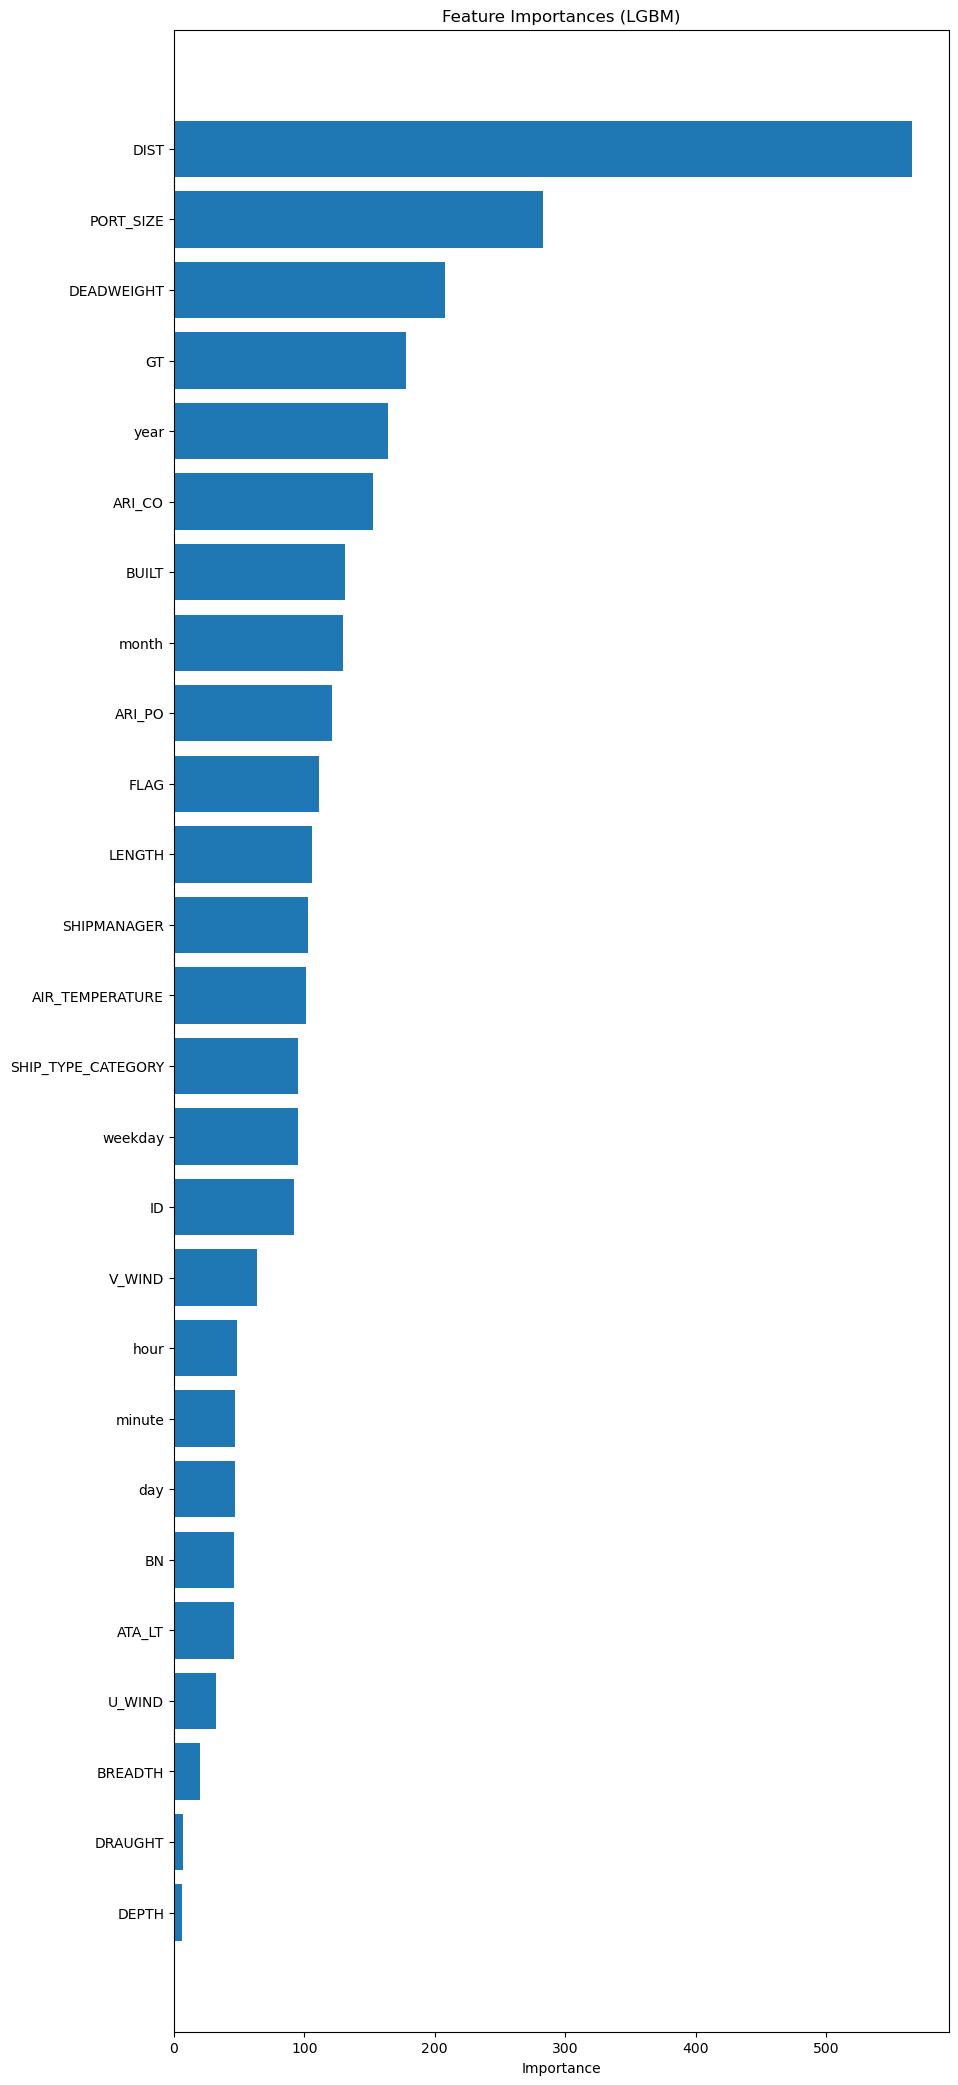

In [45]:
# Model Tune for LGBM
lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)

Model Tune for Xgboost.


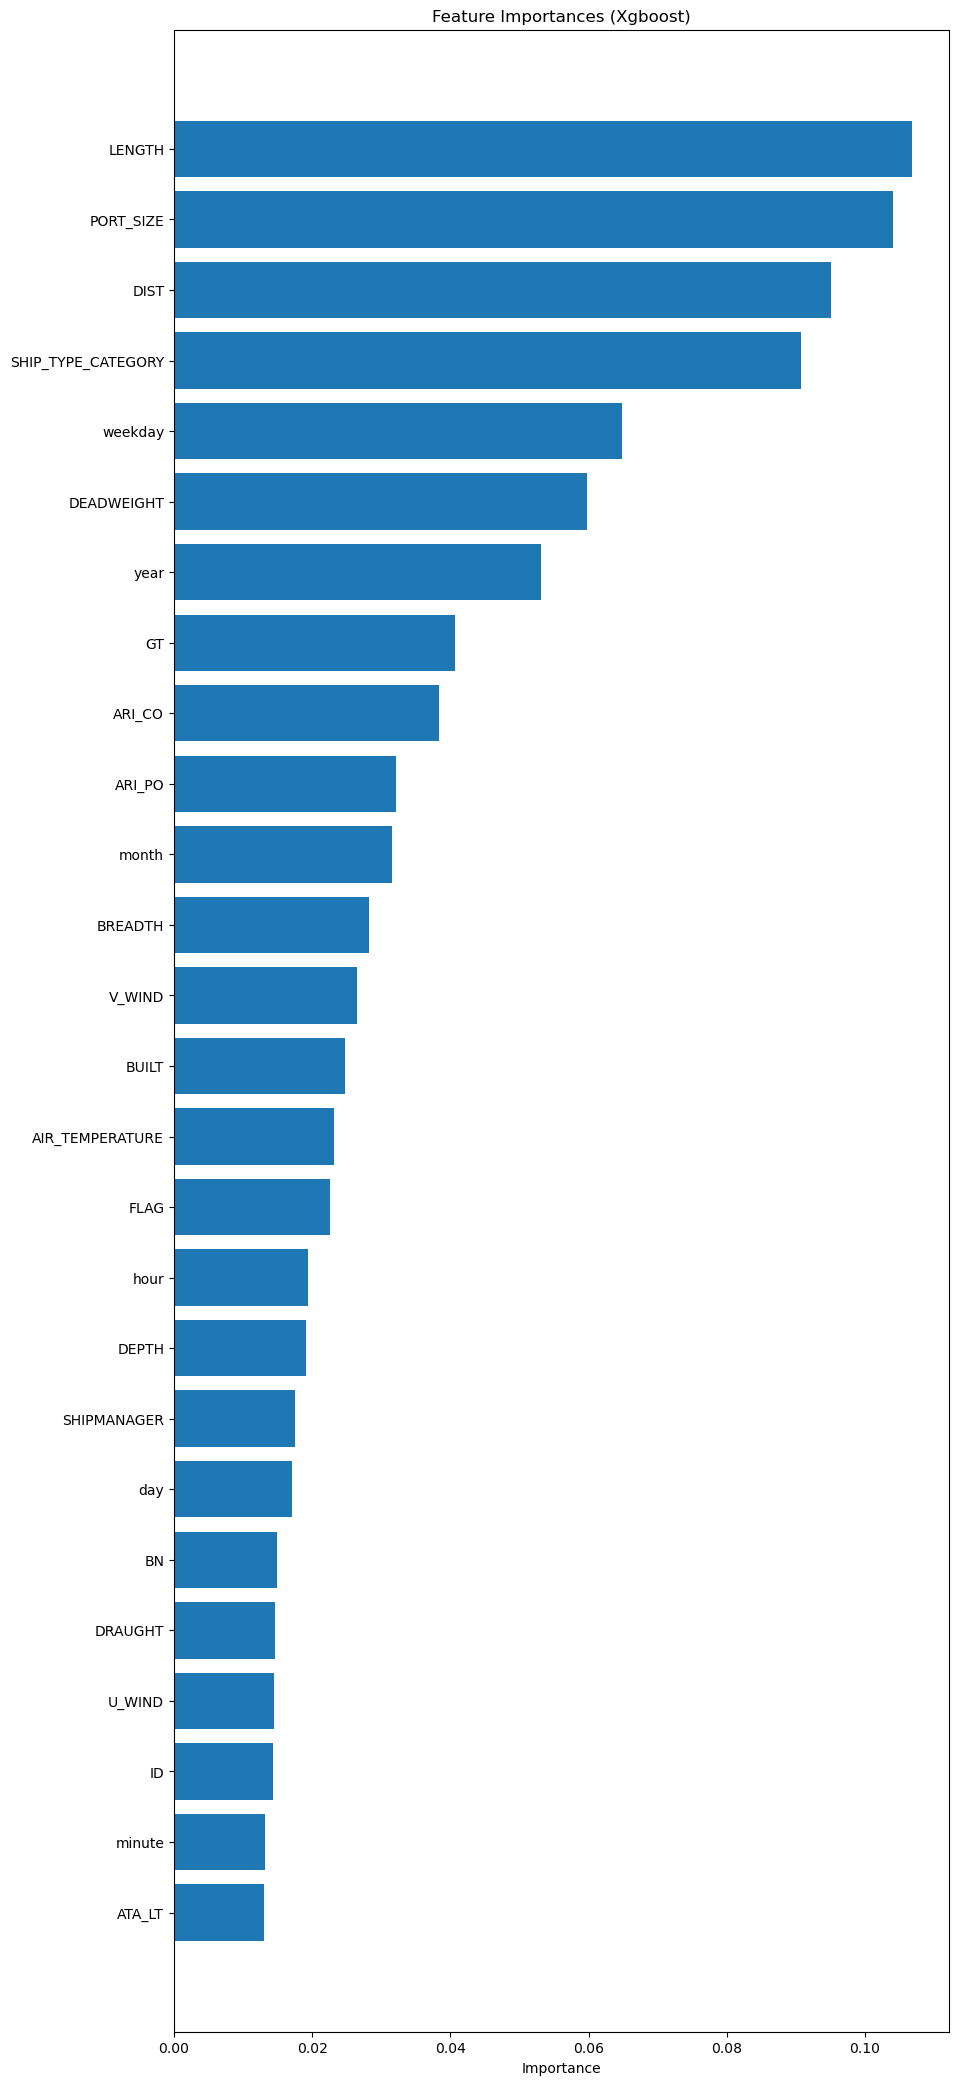

In [46]:
# Model Tune for Xgboost
xgb_model, xgb_feature_importances = train_and_evaluate(xgb.XGBRegressor(), 'Xgboost', X_train, y_train)

Model Tune for RandomForest.


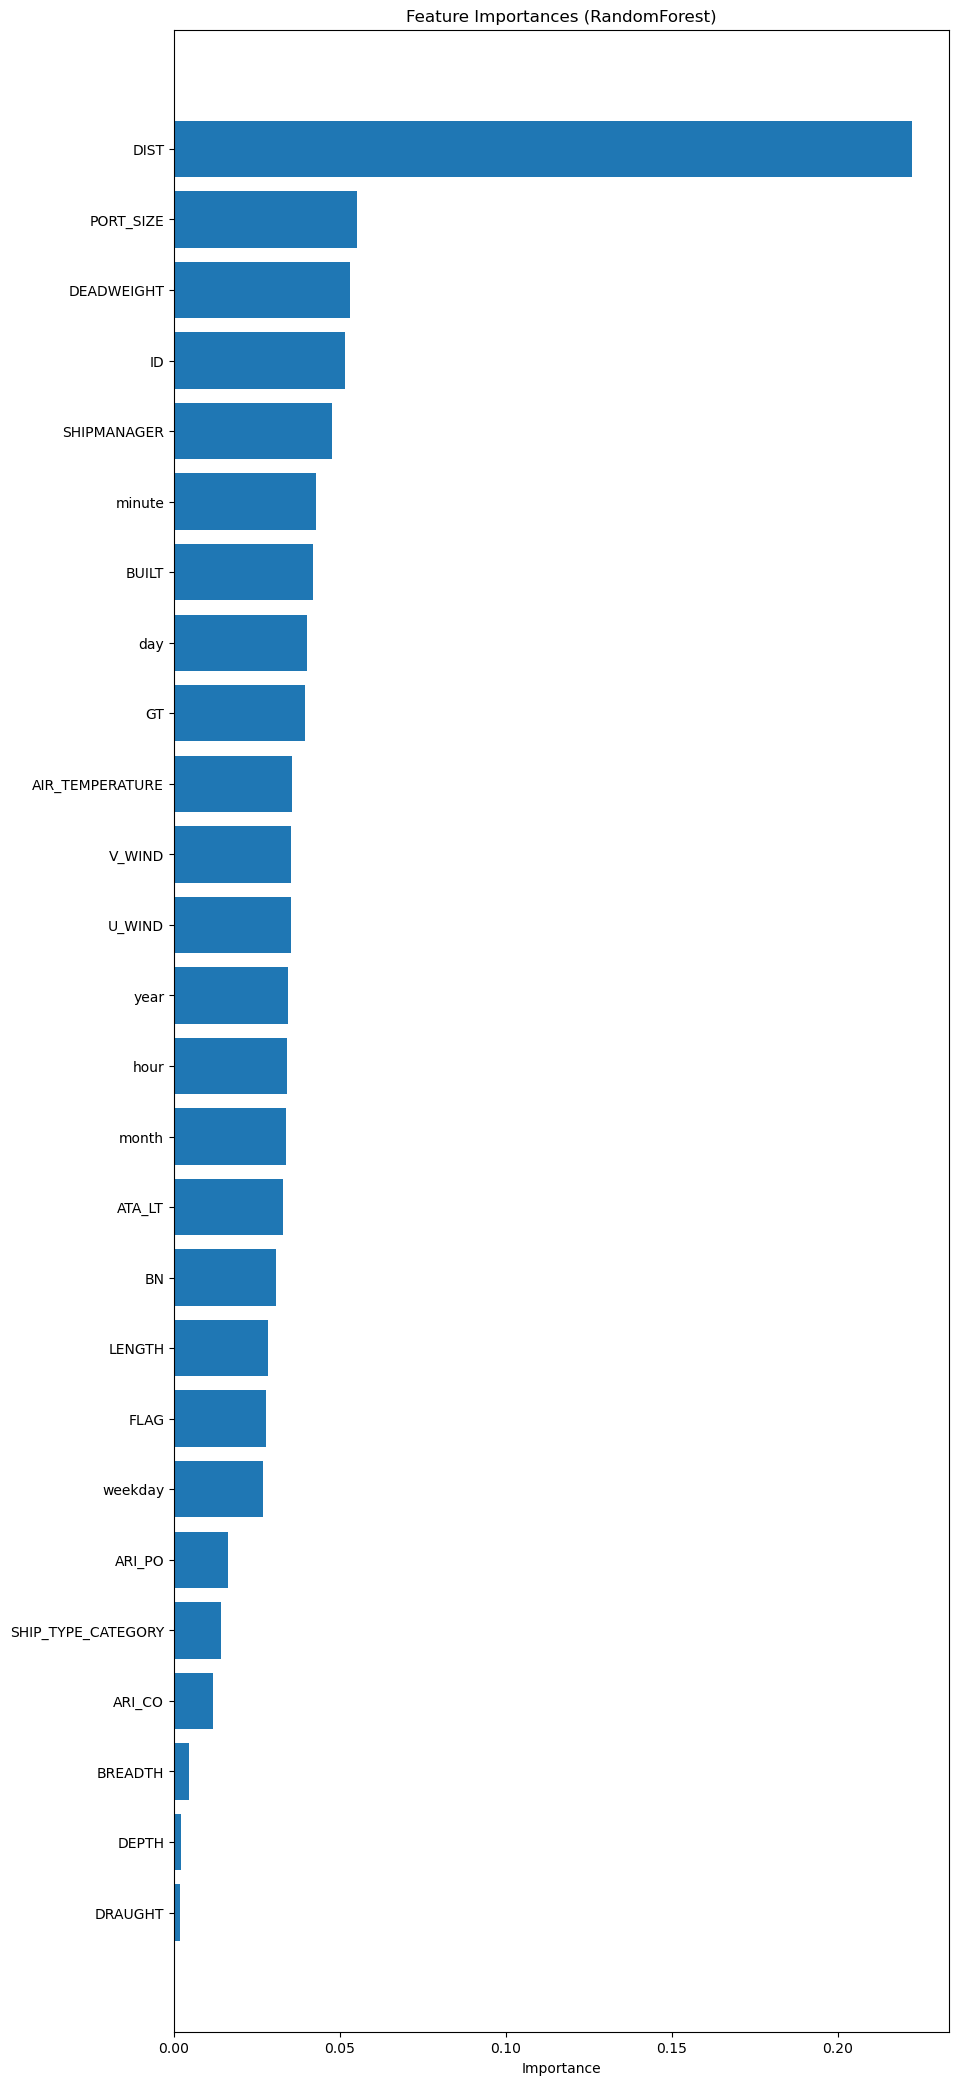

In [47]:
# Model Tune for RandomForest
rforest_model, rforest_feature_importances = train_and_evaluate(RandomForestRegressor(), 'RandomForest', X_train, y_train)

Model Tune for catboost.
Learning rate set to 0.105174
0:	learn: 168.0049289	total: 179ms	remaining: 2m 59s
1:	learn: 165.7555832	total: 196ms	remaining: 1m 37s
2:	learn: 163.8750089	total: 211ms	remaining: 1m 10s
3:	learn: 162.3817376	total: 226ms	remaining: 56.3s
4:	learn: 161.1034869	total: 241ms	remaining: 47.9s
5:	learn: 159.9661327	total: 256ms	remaining: 42.4s
6:	learn: 159.0298729	total: 271ms	remaining: 38.4s
7:	learn: 158.2520839	total: 285ms	remaining: 35.3s
8:	learn: 157.5446114	total: 299ms	remaining: 32.9s
9:	learn: 156.9404131	total: 313ms	remaining: 31s
10:	learn: 156.4380180	total: 328ms	remaining: 29.5s
11:	learn: 156.0766370	total: 342ms	remaining: 28.1s
12:	learn: 155.6060610	total: 356ms	remaining: 27s
13:	learn: 155.2344255	total: 369ms	remaining: 26s
14:	learn: 154.8751808	total: 383ms	remaining: 25.2s
15:	learn: 154.5370166	total: 397ms	remaining: 24.4s
16:	learn: 154.2361149	total: 412ms	remaining: 23.8s
17:	learn: 153.9631778	total: 427ms	remaining: 23.3s
18:	

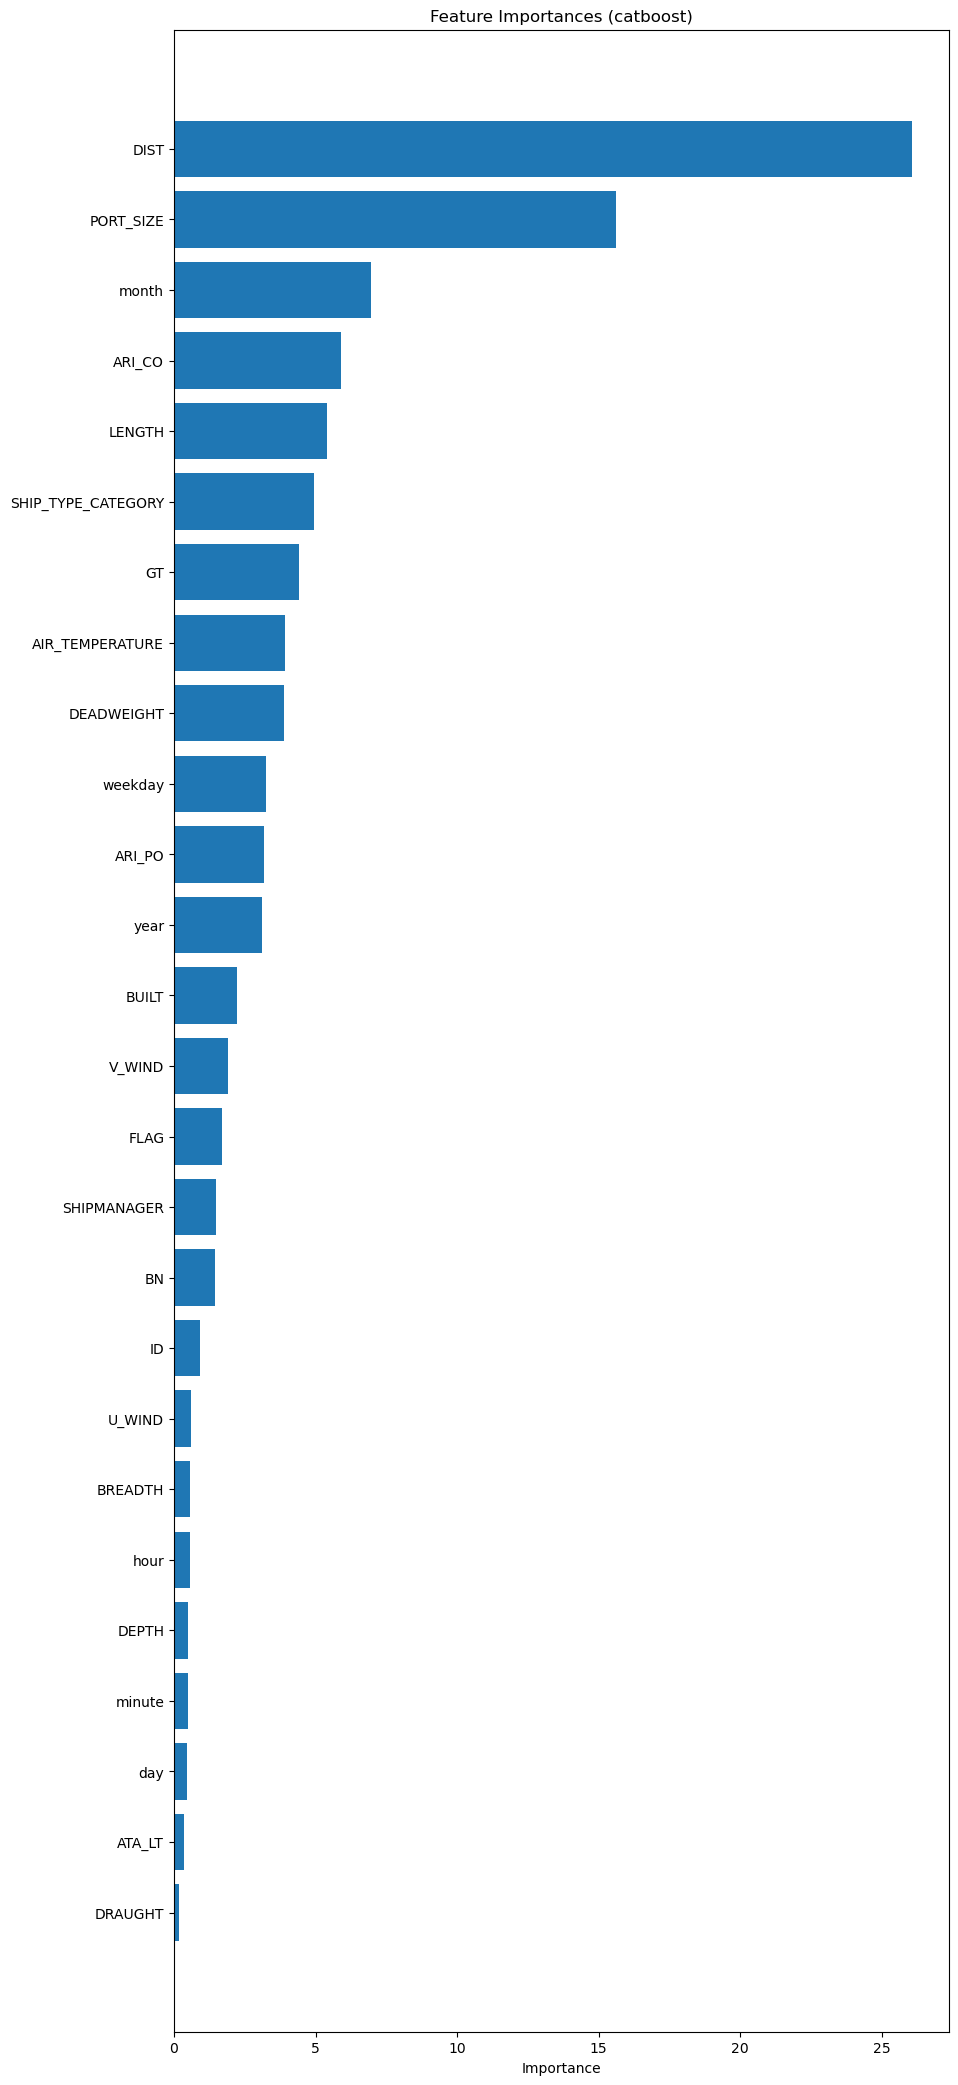

In [48]:
# Model Tune for catboost
catboost_model, catboost_feature_importances = train_and_evaluate(CatBoostRegressor(), 'catboost', X_train, y_train)

## K-Fold Model Fitting & Validation

In [53]:
# kfold 함수
def model_fitting(X_train, y_train, test, model):
    # 5-Fold 설정
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
    ensemble_predictions = []
    scores = []

    for train_idx, val_idx in tqdm(kf.split(X_train), total=5, desc="Processing folds"):
        X_t, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]
        
        # 두 모델 모두 학습
        model.fit(X_t, y_t)
        
        # 각 모델로부터 Validation set에 대한 예측을 평균내어 앙상블 예측 생성
        val_pred = model.predict(X_val)
        
        # Validation set에 대한 대회 평가 산식 계산 후 저장
        scores.append(mean_absolute_error(y_val, val_pred))
        
        # test 데이터셋에 대한 예측 수행 후 저장
        model_pred = model.predict(test)
        model_pred = np.where(model_pred < 0, 0, model_pred)
        
        ensemble_predictions.append(model_pred)

    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
    final_predictions = np.mean(ensemble_predictions, axis=0)

    # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score출력
    print("Validation : MAE scores for each fold:", scores)
    print("Validation : MAE:", np.mean(scores))
    return final_predictions

## 피처 제거, 결측치 보간 방법 실험

In [54]:
# 기본적인 전처리(ATA 컬럼처리+카테고리형 라벨인코딩+선박외형 관련 결측치 존재하는 행 제거 등등)
xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train, y_train,test, xgboost)

Processing folds: 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]

Validation : MAE scores for each fold: [56.2247161234299, 56.825609500189344, 56.875202761559855, 55.90481276021332, 55.81940106813011]
Validation : MAE: 56.329948442704506


In [55]:
# 기본+결측치 처리 mean으로
X_train_fillna=X_train.fillna(train.mean())

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_fillna, y_train,test, xgboost)

Processing folds: 100%|██████████| 5/5 [00:35<00:00,  7.19s/it]

Validation : MAE scores for each fold: [56.231063481314074, 56.93685455868415, 56.77919335698325, 55.896361850726606, 55.59158208280694]
Validation : MAE: 56.287011066103005


In [56]:
# 기본+컬럼 삭제('ID', 'DEPTH', 'DRAUGHT', 'minute')
X_train_reduced = X_train.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute'])
test_reduced = test.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute'])

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced, y_train,test_reduced, xgboost)

Processing folds: 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]

Validation : MAE scores for each fold: [56.12930442284454, 56.479357222333526, 57.102289430526106, 55.75271439080425, 55.63553574755201]
Validation : MAE: 56.21984024281208


In [57]:
# 기본+컬럼 삭제2 (결측치 많은 컬럼 다 삭제)
X_train_reduced = X_train.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])
test_reduced = test.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'])

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced, y_train,test_reduced, xgboost)

Processing folds: 100%|██████████| 5/5 [00:32<00:00,  6.49s/it]

Validation : MAE scores for each fold: [55.80639348209865, 56.69869900959911, 56.35600063072098, 55.56809131145971, 55.715136649923096]
Validation : MAE: 56.028864216760304


In [65]:
# 기본 + 결측치 knn보간
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=3)
X_train_knnimputed = imputer.fit_transform(X_train)
cols = X_train.columns.tolist()
X_train_knn = pd.DataFrame(X_train_knnimputed, columns=cols)

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_knn, y_train,test, xgboost)

Processing folds: 100%|██████████| 5/5 [00:41<00:00,  8.38s/it]

Validation : MAE scores for each fold: [56.56873412160243, 57.172160316512254, 57.3241900874723, 56.30765869103254, 56.30187753833347]
Validation : MAE: 56.73492415099061


In [66]:
# 기본 + 결측치 mice보간
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# random_state값은 원하시는 숫자 아무거나 넣으시면 됩니다.
imputer_mice = IterativeImputer(random_state=83)
X_train_mice= imputer_mice.fit_transform(X_train) #ndarray

cols = X_train.columns.tolist()
X_train_mice = pd.DataFrame(X_train_mice, columns=cols)

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_mice, y_train,test, xgboost)

Processing folds: 100%|██████████| 5/5 [00:39<00:00,  7.90s/it]

Validation : MAE scores for each fold: [56.21309771275129, 57.085942163793675, 56.91380514174786, 55.787236351060834, 55.91375793848995]
Validation : MAE: 56.38276786156872


In [67]:
# 판다스 선형보간
x_inter = X_train.interpolate()
xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(x_inter, y_train,test, xgboost)

Processing folds: 100%|██████████| 5/5 [01:08<00:00, 13.74s/it]

Validation : MAE scores for each fold: [56.40285244470686, 57.040078909701755, 57.465691502750126, 56.06459271327132, 56.071803670220206]
Validation : MAE: 56.60900384813006


In [68]:
# 기본적인 전처리(ATA 컬럼처리+카테고리형 라벨인코딩) + 기상피처(결측치 많은) 다 삭제
X_train_reduced2 = X_train.drop(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], axis=1)
test_reduced2 = test.drop(['U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN'], axis=1)
xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced2, y_train,test_reduced2, xgboost)

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Processing folds: 100%|██████████| 5/5 [00:31<00:00,  6.38s/it]

Validation : MAE scores for each fold: [55.75496473838593, 56.99728625277333, 56.56366191857897, 55.99018835040062, 55.90275639483006]
Validation : MAE: 56.24177153099379


In [73]:
# 기본+컬럼 삭제... +BREADTH
X_train_reduced = X_train.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH'])
test_reduced = test.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH'])

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced, y_train,test_reduced, xgboost)

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Processing folds: 100%|██████████| 5/5 [00:30<00:00,  6.18s/it]

Validation : MAE scores for each fold: [55.70404125621252, 56.56833239318126, 56.31815258384062, 55.501560596537274, 55.54999627564581]
Validation : MAE: 55.9284166210835


In [74]:
# 기본+컬럼 삭제... +BUILT
X_train_reduced = X_train.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH', 'BUILT'])
test_reduced = test.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH', 'BUILT'])

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced, y_train,test_reduced, xgboost)

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Processing folds: 100%|██████████| 5/5 [00:31<00:00,  6.35s/it]

Validation : MAE scores for each fold: [55.93697079955326, 56.440335950831425, 56.63409561249655, 55.47767130935863, 55.604814302563284]
Validation : MAE: 56.01877759496064


In [75]:
# 기본+컬럼 삭제... +SHIPMANAGER =>many reduce
X_train_reduced = X_train.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH', 'BUILT', 'SHIPMANAGER'])
test_reduced = test.drop(columns=['ID', 'DEPTH', 'DRAUGHT', 'minute', 'U_WIND', 'V_WIND', 'AIR_TEMPERATURE', 'BN', 'BREADTH', 'BUILT', 'SHIPMANAGER'])

xgboost = xgb.XGBRegressor()
final_prediction = model_fitting(X_train_reduced, y_train,test_reduced, xgboost)

Processing folds:   0%|          | 0/5 [00:00<?, ?it/s]

Processing folds: 100%|██████████| 5/5 [00:31<00:00,  6.28s/it]

Validation : MAE scores for each fold: [55.535998479920764, 56.38723014497318, 56.570538087169794, 55.43793961714496, 55.47199008873243]
Validation : MAE: 55.88073928358823


## 그래프

볼 것:

수치형: 'DIST', 'DEADWEIGHT', 'GT', 'LENGTH', 'PORT_SIZE', 'BUILT'

범주형: 'ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'FLAG' 

시간 데이터: 'ATA_LT', 'year','month', 'day', 'hour', 'miniute', 'weekday'


In [76]:
# 라벨 인코딩 없이 진행
train = pd.read_csv('train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('test.csv').drop(columns=['SAMPLE_ID'])

### 수치형

Text(0.5, 1.0, 'BUILT')

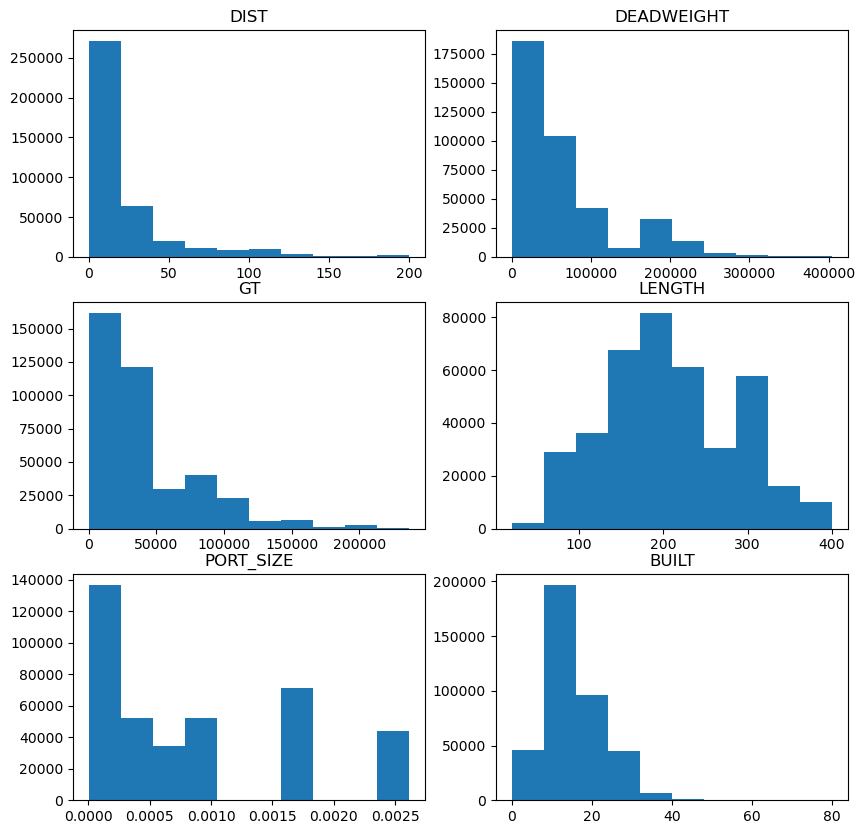

In [77]:
# 수치형 피처 히스토그램 확인
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 10))

axes[0][0].hist(train['DIST'])
axes[0][0].set_title('DIST')

axes[0][1].hist(train['DEADWEIGHT'])
axes[0][1].set_title('DEADWEIGHT')

axes[1][0].hist(train['GT'])
axes[1][0].set_title('GT')

axes[1][1].hist(train['LENGTH'])
axes[1][1].set_title('LENGTH')

axes[2][0].hist(train['PORT_SIZE'])
axes[2][0].set_title('PORT_SIZE')

axes[2][1].hist(train['BUILT'])
axes[2][1].set_title('BUILT')

### 범주형

<Axes: xlabel='SHIPMANAGER', ylabel='count'>

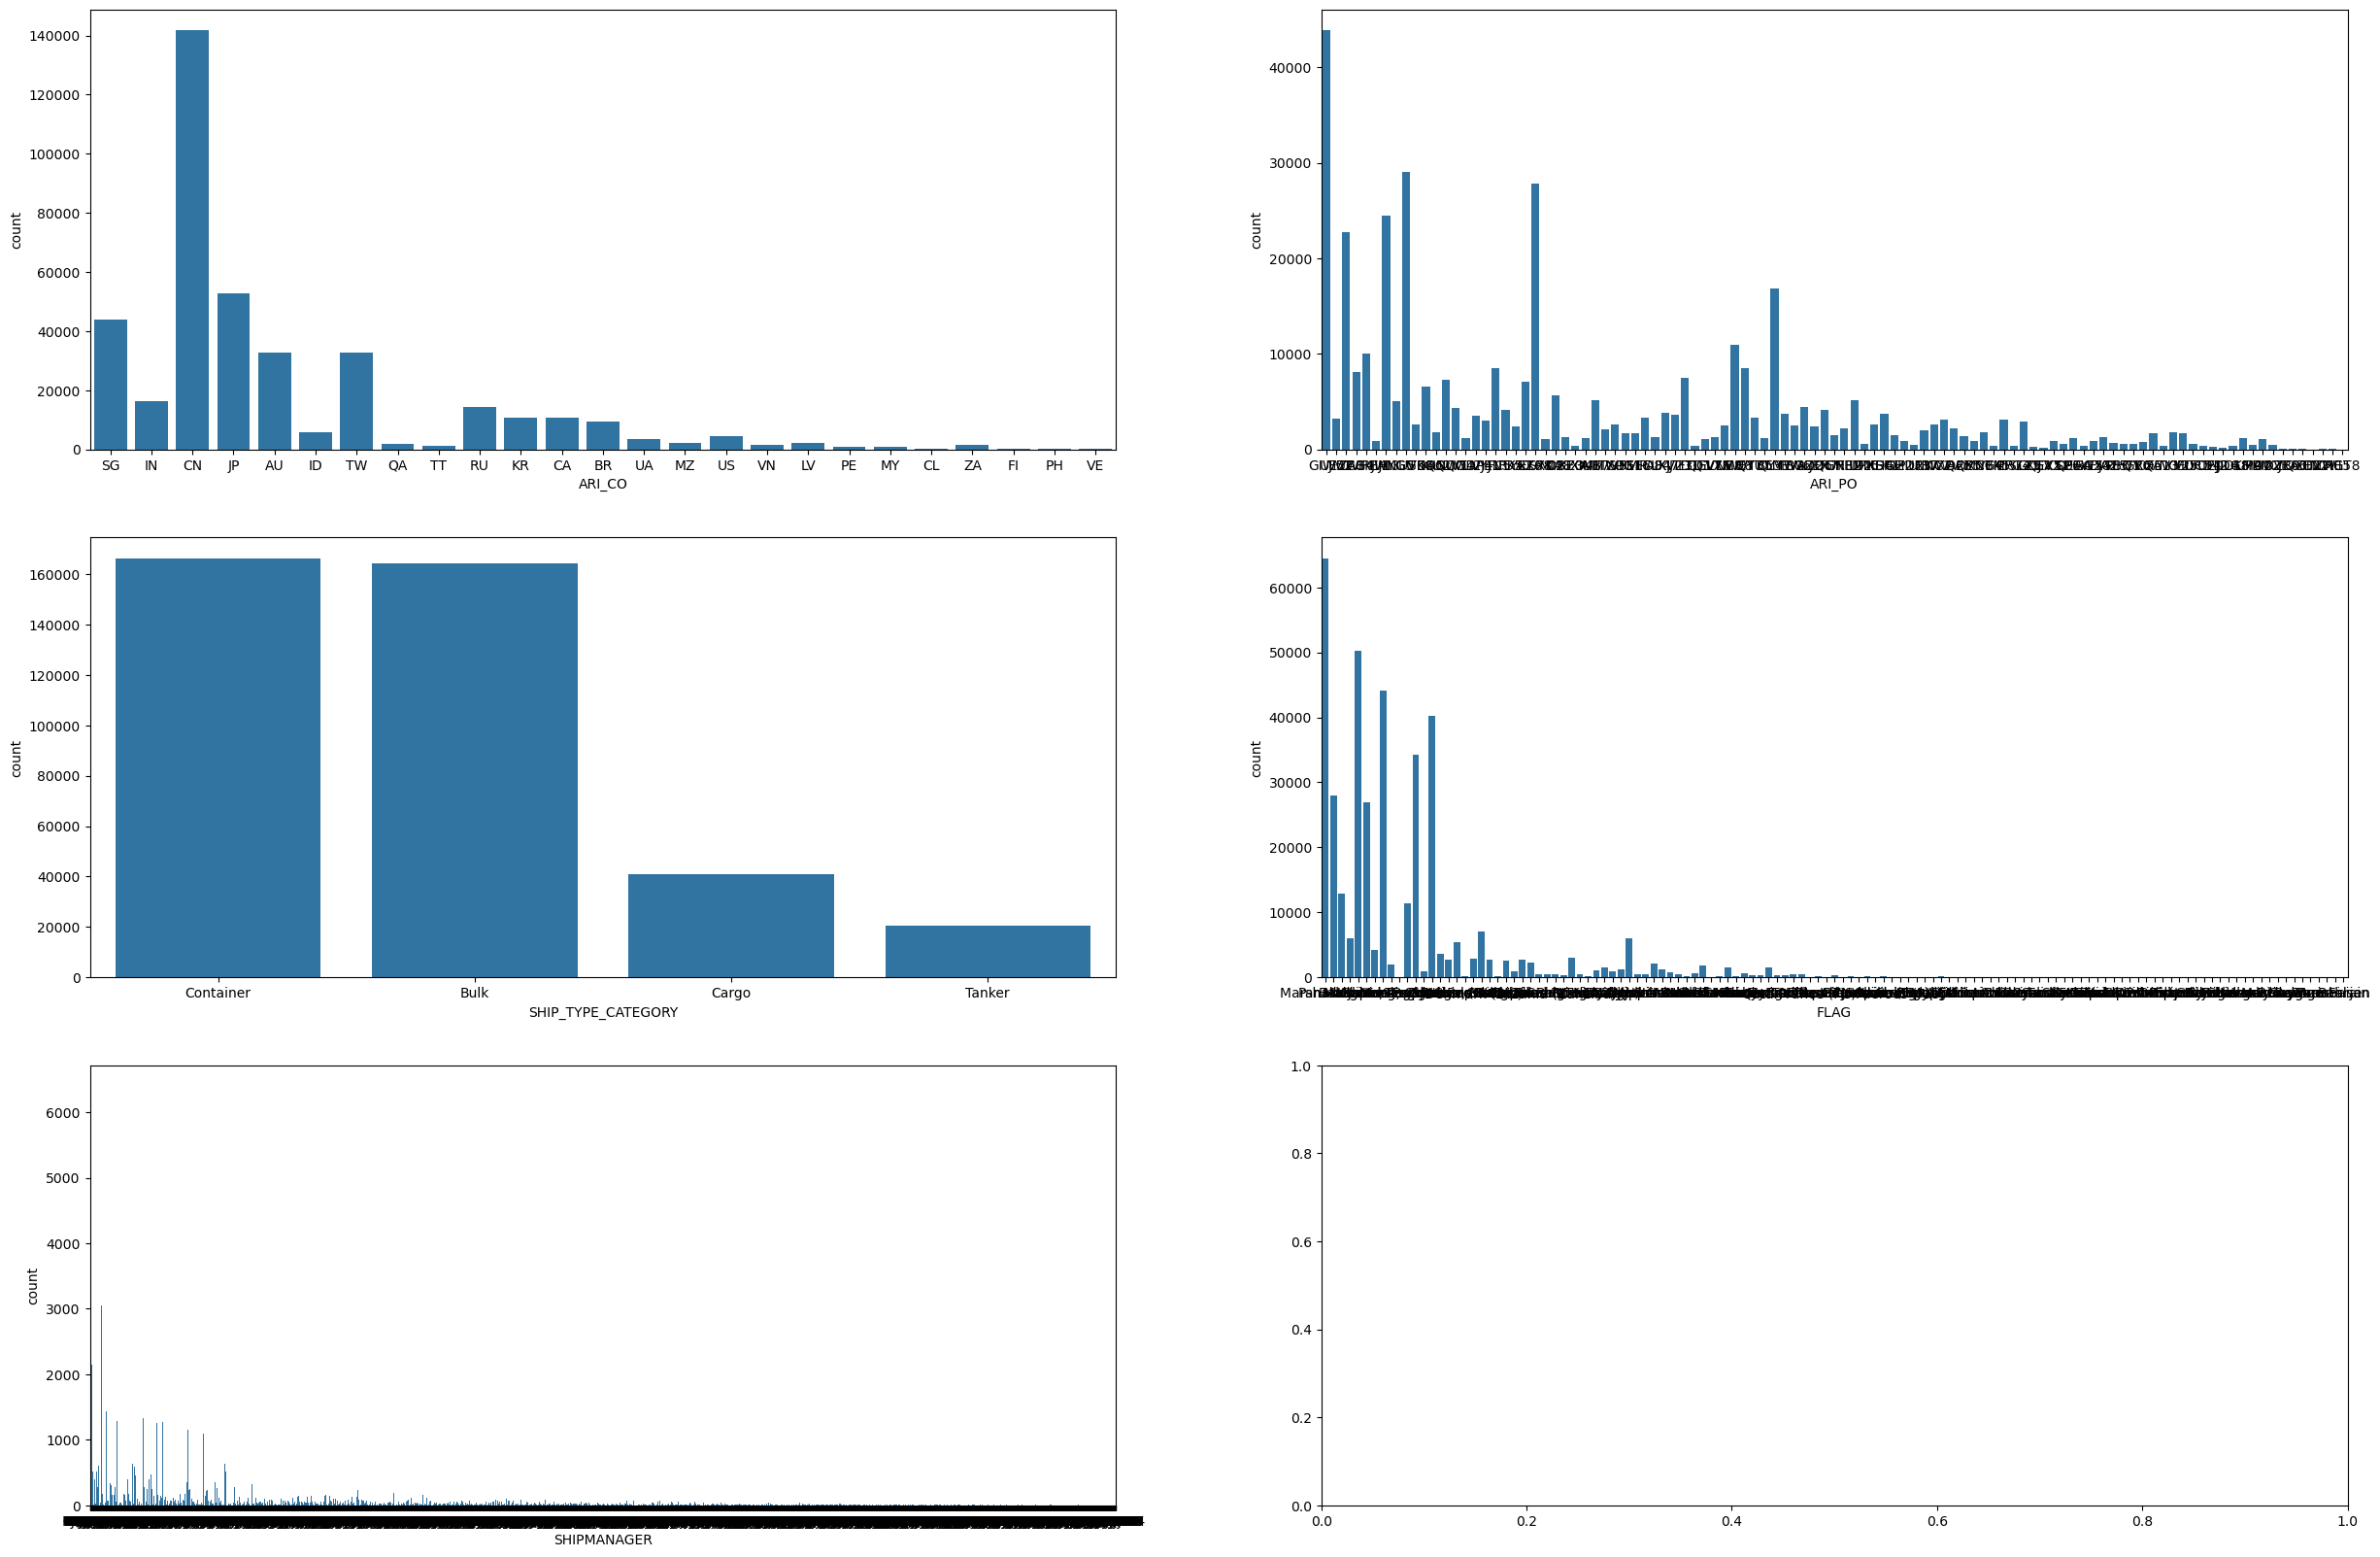

In [86]:
# 범주형 피처 countplot 확인
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(30, 20))
sns.countplot(x='ARI_CO', data=train, ax=axes[0][0])

sns.countplot(x='ARI_PO', data=train, ax=axes[0][1])

sns.countplot(x='SHIP_TYPE_CATEGORY', data=train, ax=axes[1][0])

sns.countplot(x='FLAG', data=train, ax=axes[1][1])

sns.countplot(x='SHIPMANAGER', data=train, ax=axes[2][0])

In [79]:
# ARI_CO 피처 unique한 값 확인
train['ARI_CO'].unique()

array(['SG', 'IN', 'CN', 'JP', 'AU', 'ID', 'TW', 'QA', 'TT', 'RU', 'KR',
       'CA', 'BR', 'UA', 'MZ', 'US', 'VN', 'LV', 'PE', 'MY', 'CL', 'ZA',
       'FI', 'PH', 'VE'], dtype=object)

In [80]:
# ARI_PO 피처 unique한 값 확인
train['ARI_PO'].unique()

array(['GIW5', 'UJM2', 'EUC8', 'ZAG4', 'WHH4', 'REJ1', 'JWI3', 'HYG5',
       'NGG6', 'UVK6', 'TDA5', 'KIU2', 'QQW1', 'NQO4', 'IVU2', 'YDP4',
       'VYJ1', 'JEN5', 'FCD5', 'RKA2', 'YRT6', 'EKP8', 'SXD2', 'MIA8',
       'OBZ3', 'XEO4', 'XIU1', 'AIB7', 'MMW5', 'TXO3', 'SPG1', 'PEL6',
       'VFD8', 'PAF4', 'LXJ7', 'XVZ3', 'JTD1', 'FTQ1', 'QGL7', 'EVL6',
       'VXM8', 'NCU8', 'WEY7', 'QTU5', 'TBL3', 'QYY1', 'TMW2', 'IEW6',
       'BGD2', 'AZU6', 'JER7', 'QGN3', 'URE2', 'FFM2', 'UPI6', 'DMD4',
       'KSF1', 'HGH2', 'OZD2', 'PUF3', 'UIR7', 'NNC2', 'WXQ2', 'WAF5',
       'BAZ5', 'QRN3', 'MCG4', 'YFK5', 'TMR7', 'EFG4', 'SLZ5', 'GQJ7',
       'XGX5', 'EVX2', 'CSP6', 'QEA4', 'UEW5', 'BGX4', 'EIA2', 'JGL5',
       'PBQ1', 'HYV6', 'GRQ5', 'CXL1', 'FAV3', 'TYY2', 'CEI5', 'MOC5',
       'URD4', 'DEJ2', 'PDL4', 'JDG8', 'OKM4', 'LHD1', 'PPM2', 'OOV8',
       'XZF6', 'JEA6', 'QXE2', 'DIN2', 'ONW1', 'ZME5', 'RGT8'],
      dtype=object)

In [81]:
# ARI_PO 이름 앞에서 2개 잘라서 unique한 값 개수 보기
print(len([x[:2] for x in train['ARI_PO'].unique()]))
print(len(set([x[:2] for x in train['ARI_PO'].unique()])))

103
95


In [82]:
# ARI_PO 이름 앞에서 3개 잘라서 unique한 값 개수 보기
print(len([x[:3] for x in train['ARI_PO'].unique()]))
print(len(set([x[:3] for x in train['ARI_PO'].unique()])))

103
103


In [85]:
# FLAG 피처 unique한 값 확인
train['FLAG'].unique()

array(['Panama', 'Marshall Islands', 'Malta', 'Bahamas', 'Liberia',
       'Japan', 'Indonesia', 'Hong Kong, China', 'United Kingdom',
       'Montenegro', 'Korea, South', 'Singapore', 'Barbados',
       "China, People's Republic Of", 'Belize', 'Comoros',
       'Portugal (Mar)', 'Korea, North', 'Denmark (Dis)',
       'Chinese Taipei', 'Greece', 'Croatia', 'Vietnam', 'Bangladesh',
       'India', 'Palau', 'Canada', 'Gabon', 'Tanzania (Zanzibar)',
       'Belgium', 'Russia', 'Togo', 'Niue', 'Norway (Nis)',
       'St Kitts & Nevis', 'Thailand', 'Malaysia', 'Cyprus',
       'Philippines', 'Cayman Islands', 'Antigua & Barbuda', 'Unknown',
       'United States Of America', 'Iran', 'Nauru', 'Netherlands',
       'Isle Of Man', 'Israel', 'Cook Islands', 'Germany',
       'United Arab Emirates', 'Turkey', 'Vanuatu', 'Qatar',
       'Sierra Leone', 'Mongolia', 'Brazil', 'Tuvalu',
       'St Vincent & The Grenadines', 'Finland', 'France (Fis)',
       'Cameroon', 'Italy', 'New Zealand', 'Gibr

In [97]:
# SHIPMANAGER 피처 unique한 값 개수 확인
print(len(train['SHIPMANAGER'].unique()))

6511


In [104]:
# SHIPMANAGER 피처 unique한 값 확인
np.set_printoptions(threshold=6511)
a=train['SHIPMANAGER'].unique()
print(a)

['CHMT36' 'CUFV52' 'ISIG88' 'MWFU27' 'OXZY41' 'EDEF46' 'TPVK28' 'YQFC33'
 'PBHC63' 'NSYA42' 'PSPJ35' 'ZDSQ63' 'PCPB42' 'BSQW77' 'RXZU17' 'IPCA74'
 'VWGS43' 'CAXH37' 'CVDP86' 'IQZX28' 'ARUK64' 'VMQN88' 'PCRT46' 'TABE78'
 'DLCF82' 'TEOP42' 'WTKX14' 'PIIS74' 'XDBO87' 'WAIS64' 'RCOZ78' 'UPVL67'
 'ZUXT65' 'ALEP68' 'HENE86' 'AVTT66' 'LZKK73' 'GRJG55' 'HUUC18' 'PDBD74'
 'HKNU26' 'KQMD74' 'AAOY77' 'PYFY77' 'MYML77' 'PBZV77' 'PHDW83' 'DXFI87'
 'BGWI26' 'FATU11' 'SIEL54' 'HILS35' 'KTEC45' 'UOWJ77' 'CRGI31' 'GXMM51'
 'NHFM26' 'ISAX42' 'ZXPI27' 'LKQN15' 'EQAU25' 'KEJZ24' 'JVWA55' 'XTRQ46'
 'RCGL58' 'EXRQ58' 'ZPUZ74' 'CUKD35' 'HZSD87' 'HCYG42' 'GLHT86' 'JFOO65'
 'LTMA27' 'PBNA32' 'JDQN12' 'XWVE56' 'LHKK28' 'BMPC83' 'PKZE35' 'CRKF84'
 'GHZH12' 'RRJQ41' 'QTYI17' 'ULZL14' 'PJTN56' 'IYGV66' 'FNLX72' 'LKLG84'
 'FLVH78' 'TUZU25' 'TCMF26' 'OKOF41' 'VDMF46' 'CEFN65' 'HZUO14' 'PGLA48'
 'ODKA48' 'EVTO72' 'NSFW31' 'QLMN35' 'HVUI66' 'GXKR25' 'EAFE55' 'HUEI64'
 'WQGJ23' 'QQMM24' 'EKFV15' 'RVLS31' 'NLTW61' 'PCAW

In [87]:
# SHIPMANAGER 이름 앞에서 2,3, 4개 잘라서 unique한 값 개수 보기
print(len([x[:2] for x in train['SHIPMANAGER'].unique()]))
print(len(set([x[:2] for x in train['SHIPMANAGER'].unique()])))
print()
print(len([x[:3] for x in train['SHIPMANAGER'].unique()]))
print(len(set([x[:3] for x in train['SHIPMANAGER'].unique()])))
print()
print(len([x[:4] for x in train['SHIPMANAGER'].unique()]))
print(len(set([x[:4] for x in train['SHIPMANAGER'].unique()])))

6566
677

6566
5523

6566
6523


In [88]:
train['SHIPMANAGER'].max()

'ZZZE24'

### 날짜, 시간

전처리 하고 진행

<Axes: xlabel='weekday', ylabel='count'>

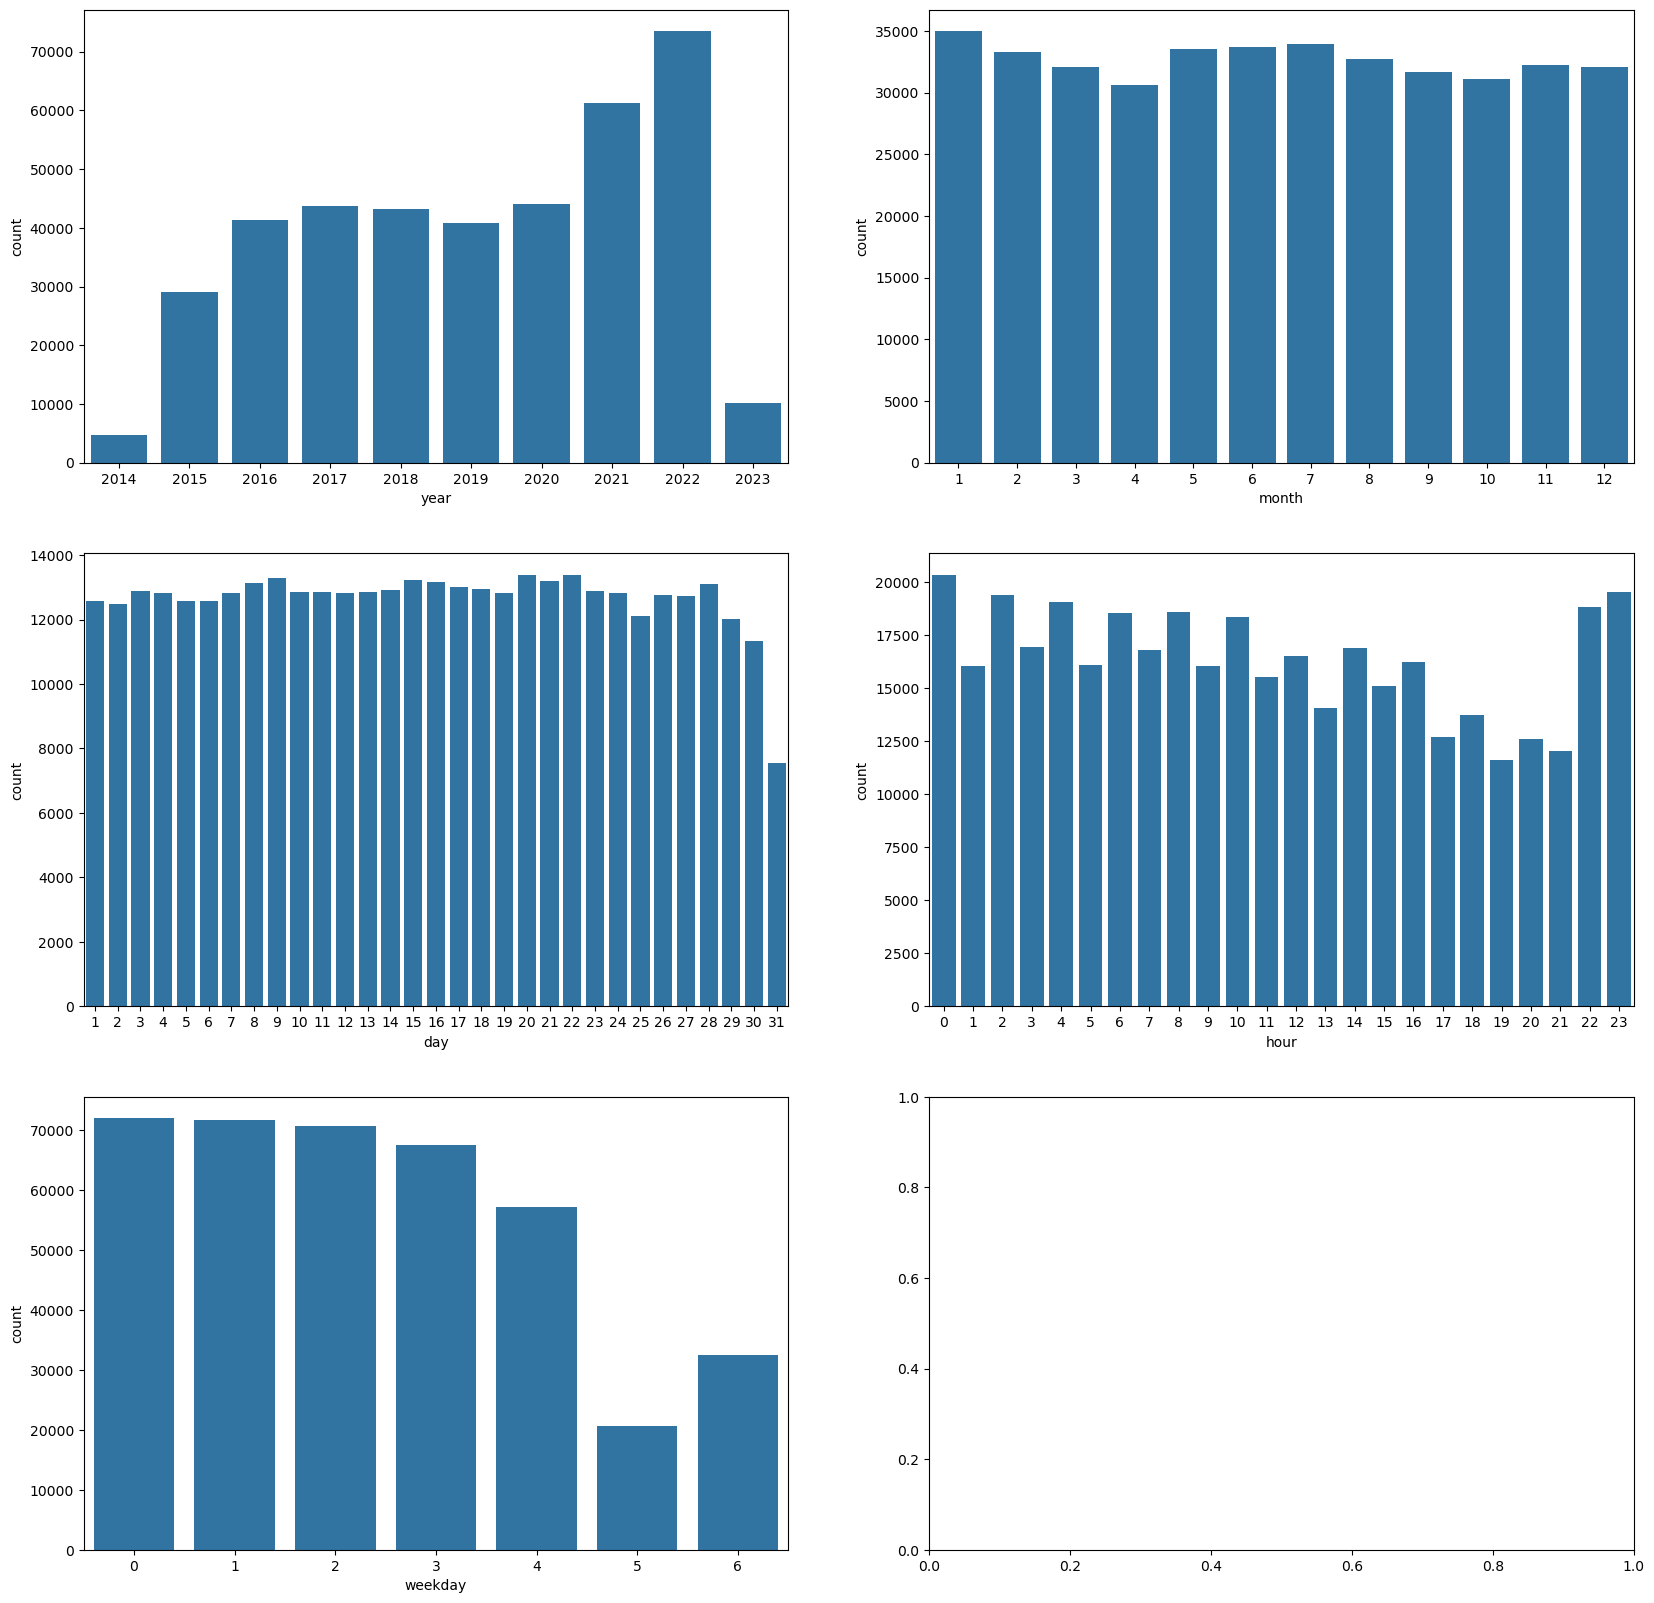

In [91]:
# 날짜, 시간 관련 피처 countplot 확인
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20, 20))
sns.countplot(x='year', data=train, ax=axes[0][0])

sns.countplot(x='month', data=train, ax=axes[0][1])

sns.countplot(x='day', data=train, ax=axes[1][0])

sns.countplot(x='hour', data=train, ax=axes[1][1])

sns.countplot(x='weekday', data=train, ax=axes[2][0])

Text(0.5, 1.0, 'ATA_LT')

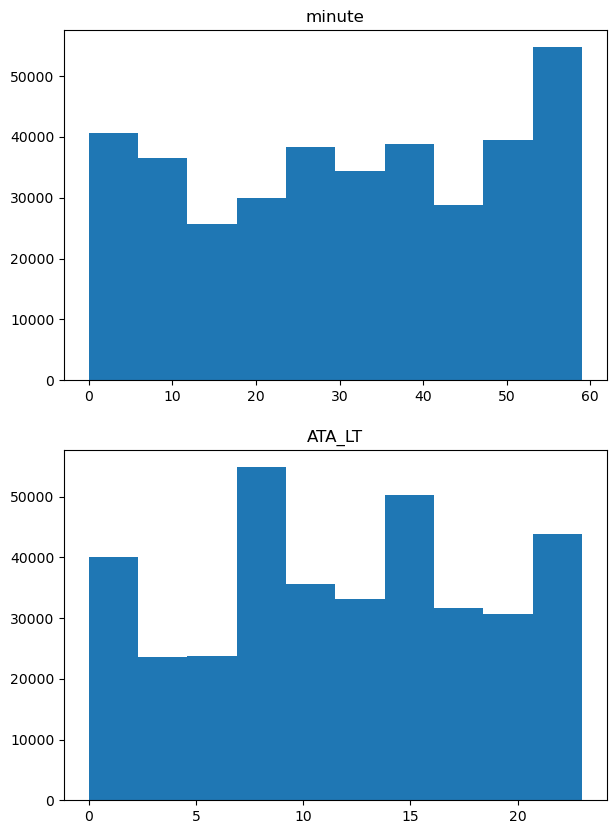

In [54]:
# 분, ATA_LT 히스토그램 확인
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(7, 10))
axes[0].hist(train['minute'])
axes[0].set_title('minute')

axes[1].hist(train['ATA_LT'])
axes[1].set_title('ATA_LT')

In [55]:
# ATA_LT의 unique한 값 확인
train['ATA_LT'].unique()

array([12, 10, 14,  7, 22,  6, 15, 18, 11,  9, 23,  8,  1, 21,  2,  3, 20,
       16,  4, 19,  5, 13, 17,  0], dtype=int64)

In [72]:
# hour의 unique한 값 확인
train['hour'].unique()

array([ 4,  2,  6, 22, 12, 14, 21,  3,  7, 10, 13, 23, 17, 19, 11,  0,  1,
       16,  8, 15,  5, 18,  9, 20], dtype=int64)

In [71]:
# hour - ATA_LT (UTC시간 - 로컬시간)
a = train['hour']- train['ATA_LT']

In [74]:
# hour - ATA_LT의 unique값
a.unique()

array([ -8,  15,  -2,  -9, -11,  13,  16, -10,   4,  -7,   2,  -3,  -5,
        14,   5,  18,  22,   3,  17,  19,  -6,  21, -20, -22, -19, -21,
        -4,  20], dtype=int64)

<Axes: xlabel='hour', ylabel='ATA_LT'>

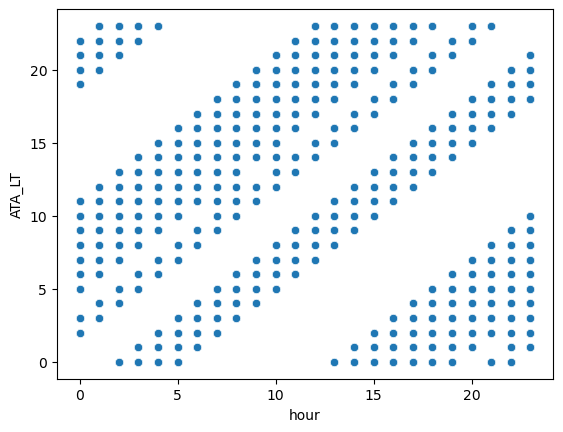

In [82]:
# hour과 ATA_LT 기준으로 산점도 그리기
sns.scatterplot(x='hour', y='ATA_LT', data=train)

### 상관관계

<Axes: >

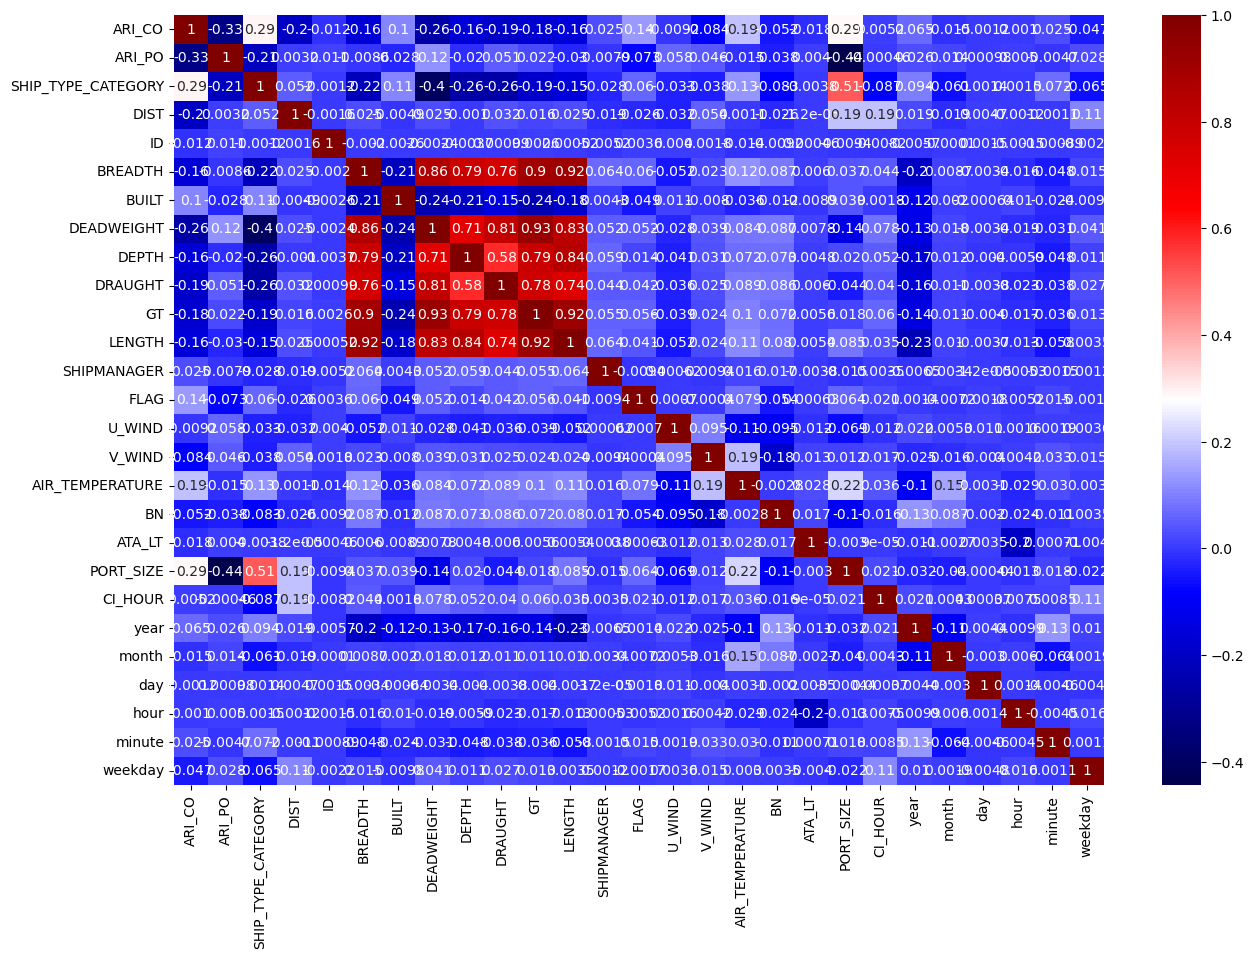

In [5]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), annot=True, cmap='seismic')

<Axes: >

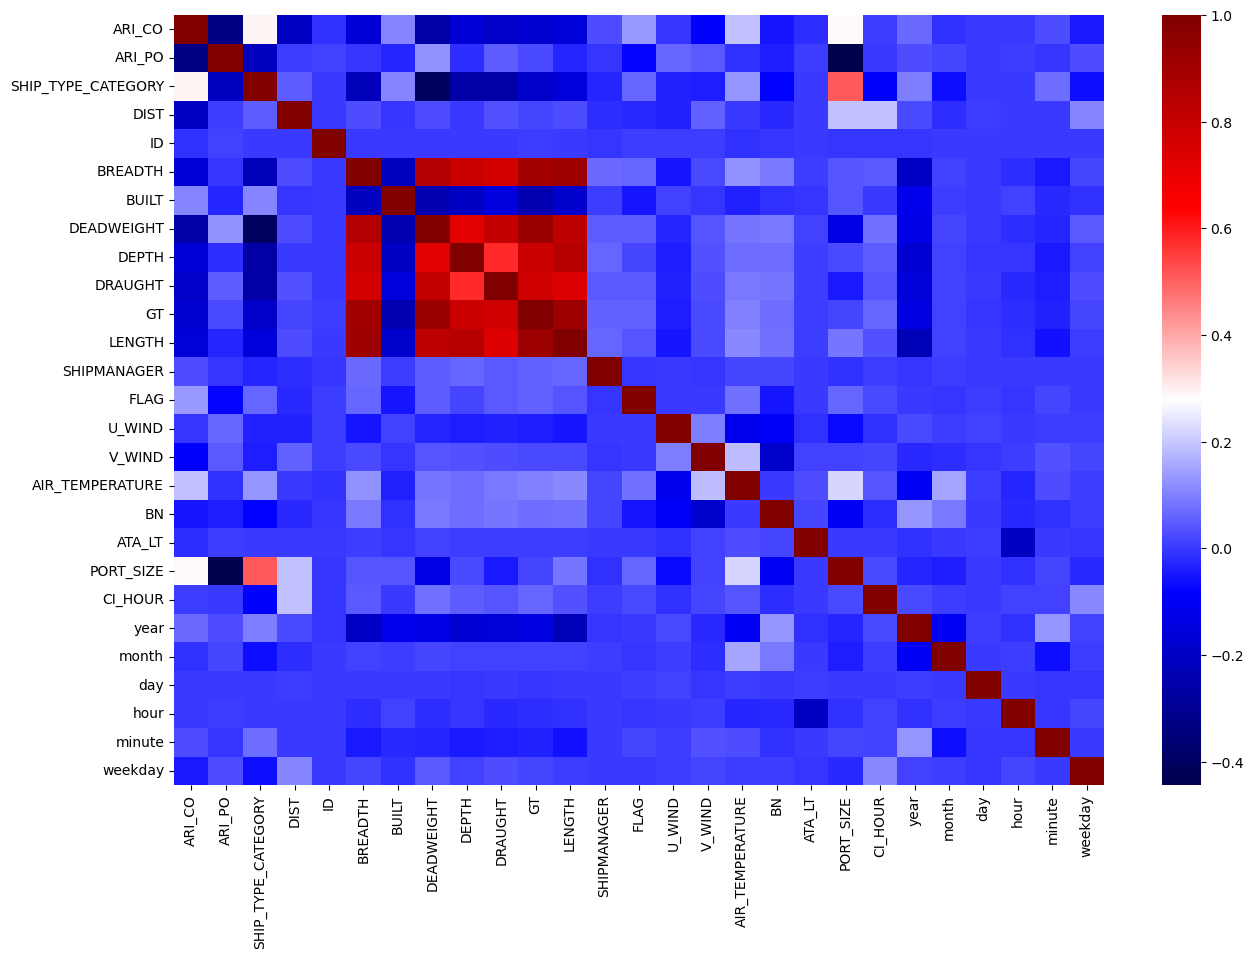

In [6]:
plt.figure(figsize=(15, 10))
sns.heatmap(train.corr(), cmap='seismic')